In [1]:
#|default_exp resnet

# ResNets
In this notebook, we are attempting to improve our best validation score on the Fashion-MNIST dataset. We will try the following:
- ResNet
- wider/deeper models
- data augmentation

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [5]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## Deeper models
We are going to try and get our model to be deeper. We will add an extra layer with 128 filters. To do this, we need our first convolution layer to have stride of 1 so that we preserve the height and width of the matrix after the first convolution.

In [7]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [8]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.806,0.000,0,train
0.836,0.000,0,eval
0.885,0.000,1,train
0.864,0.000,1,eval
0.909,0.000,2,train
0.907,0.000,2,eval
0.927,0.000,3,train
0.910,0.000,3,eval
0.942,0.000,4,train
0.923,0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


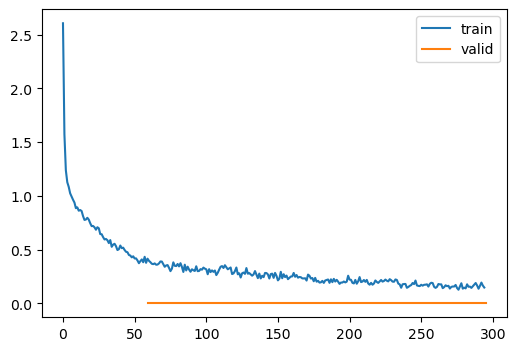

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [9]:
learn.fit(epochs)

## Skip connections
ResNet was introduced in 2015 by Kaiming He et al in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

One of the insights in this paper was that a model with 56 convolution layers underperforms a model with 20 convolution layers on both train and test error. In addition, using a constructed model with 20 convolution layers and 36 identity layers gives a baseline performance for 56 layers. Yet a model with a properly initialised 56 layers still underperforms this constructed model. This shows that solvers find it very challenging to fit a deep neural network due to tendencies of vanishing/exploding gradients.

The key idea is to use skip connections- passing the input directly to the output of 2 convolution layers to prevent vanishing gradient.

In [11]:
??conv

Signature:
conv(
    ni,
    nf,
    ks=3,
    stride=2,
    act=<class 'torch.nn.modules.activation.ReLU'>,
    norm=None,
    bias=None,
)
Docstring: <no docstring>
Source:   
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)
File:      ~/Documents/code/pdlfc/miniai/init.py
Type:      function

In [16]:
#|export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    # first layer to have stride = 1 to maintain input size
    # second layer to have act as None as we will be writing that in the ResBlock code
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride=stride, act=act_gr, ks=ks, norm=norm)
        # stride = 1 -> kernel just 'copies' each input grid, model will learn best value
        self.idconv = fc.noop if ni == nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [17]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [19]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False) # get a sense of the model

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


In [22]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [23]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


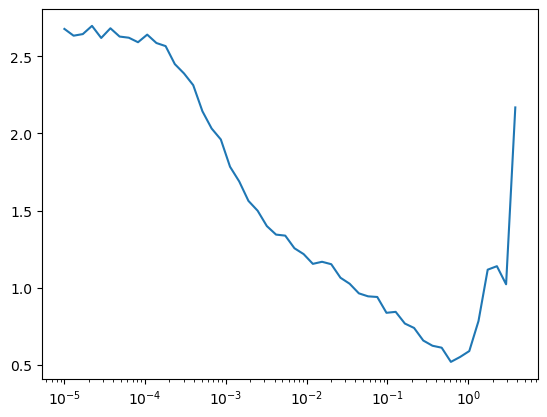

In [24]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [25]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.809,0.000,0,train
0.871,0.000,0,eval
0.892,0.000,1,train
0.883,0.000,1,eval
0.917,0.000,2,train
0.895,0.000,2,eval
0.936,0.000,3,train
0.926,0.000,3,eval
0.954,0.000,4,train
0.931,0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

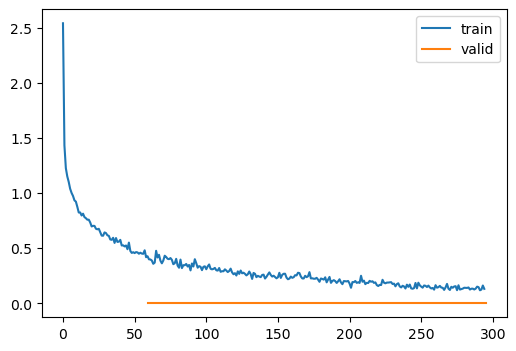

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [26]:
learn.fit(epochs)

## Export

In [30]:
import nbdev; nbdev.export.nb_export('13_resnet.ipynb', lib_path='miniai')